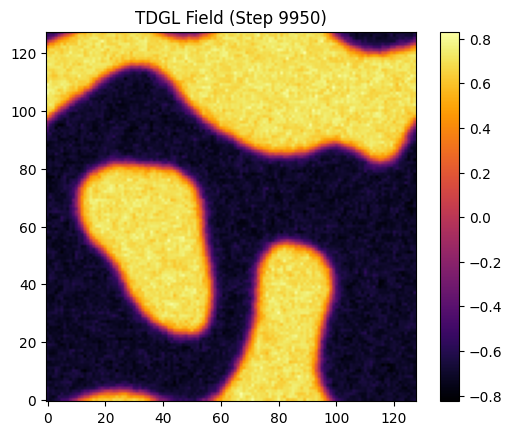

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# =======================
# 参数（可按需求调整）
# =======================
Nx, Ny = 128, 128    # 网格大小
dx = 1.0              # 网格间距
dt = 0.01             # 时间步长
n_steps = 10000        # 总步数
output_interval = 50  # 每多少步显示一次

# Landau-Ginzburg 参数（TDGL）
a = -0.5              # 控制有序/无序相（a<0 → 系统倾向形成有序结构）
b = 1.0               # 四次项系数，通常取正即可
kappa = 1.0           # 梯度项权重，控制界面的平滑程度
Gamma = 1.0           # 动力学系数

noise_strength = 0.1  # 噪声强度（随机扰动）

# 初始条件：随机小扰动
phi = 0.1 * np.random.randn(Nx, Ny)

# =======================
# 二维拉普拉斯算子（周期边界）
# =======================
def laplacian_2d(field, dx):
    f_up = np.roll(field, -1, axis=0)
    f_down = np.roll(field, 1, axis=0)
    f_left = np.roll(field, -1, axis=1)
    f_right = np.roll(field, 1, axis=1)
    lap = (f_up + f_down + f_left + f_right - 4 * field) / (dx ** 2)
    return lap

# =======================
# TDGL 时间演化
# =======================
plt.figure(figsize=(6,6))

for step in range(n_steps):

    lap_phi = laplacian_2d(phi, dx)

    # dF/dphi = a*phi + b*phi^3 - kappa * Laplacian(phi)
    force = a * phi + b * phi**3 - kappa * lap_phi

    # 噪声
    eta = noise_strength * np.random.randn(Nx, Ny)

    # 显式 Euler 更新
    phi += -Gamma * force * dt + eta * np.sqrt(dt)

    # 动态更新可视化
    if step % output_interval == 0:
        clear_output(wait=True)
        plt.imshow(phi.T, origin='lower', cmap='inferno')
        plt.colorbar()
        plt.title(f"TDGL Field (Step {step})")
        plt.show()


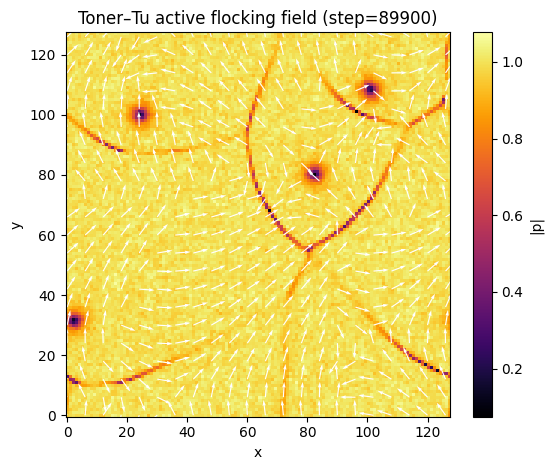

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# ==========================================
# 1. 参数区（可以根据需要修改）
# ==========================================
Nx, Ny = 128, 128      # 空间网格大小
dx = 1.0               # 网格间距
dt = 0.01              # 时间步长
n_steps = 90000         # 总演化步数
output_interval = 100   # 每多少步刷新一次图像

# Toner–Tu 模型参数
alpha = 0.5            # 线性增长（>0 有利于有序）
beta = 0.5             # 限制 |p| 不发散（>0）
D = 0.5                # 梯度项系数（类似粘性/扩散）
lam = 1.0              # 自推进 / 对流项强度 lambda
noise_strength = 0.05  # 噪声强度

# 初始条件：小随机方向
px = 0.1 * np.random.randn(Nx, Ny)
py = 0.1 * np.random.randn(Nx, Ny)

# ==========================================
# 2. 数值工具：拉普拉斯 + 空间导数（周期边界）
# ==========================================
def laplacian_2d(field, dx):
    f_up    = np.roll(field, -1, axis=0)
    f_down  = np.roll(field,  1, axis=0)
    f_left  = np.roll(field, -1, axis=1)
    f_right = np.roll(field,  1, axis=1)
    lap = (f_up + f_down + f_left + f_right - 4.0 * field) / (dx ** 2)
    return lap

def grad_2d(field, dx):
    """
    返回 (dfield/dx, dfield/dy) ，采用中心差分 + 周期边界
    """
    f_x_plus  = np.roll(field, -1, axis=0)
    f_x_minus = np.roll(field,  1, axis=0)
    f_y_plus  = np.roll(field, -1, axis=1)
    f_y_minus = np.roll(field,  1, axis=1)

    dfdx = (f_x_plus - f_x_minus) / (2.0 * dx)
    dfdy = (f_y_plus - f_y_minus) / (2.0 * dx)
    return dfdx, dfdy

# ==========================================
# 3. 主循环：Toner–Tu 动力学
# ==========================================
plt.figure(figsize=(7, 6))

for step in range(n_steps):

    # 速度模长 |p|
    p2 = px**2 + py**2
    p_mag = np.sqrt(p2 + 1e-12)  # 防止除零

    # 梯度项（扩散） D ∇^2 p
    lap_px = laplacian_2d(px, dx)
    lap_py = laplacian_2d(py, dx)

    # 对流项 (p · ∇) p
    # 先算 p_x 和 p_y 的梯度
    dpx_dx, dpx_dy = grad_2d(px, dx)
    dpy_dx, dpy_dy = grad_2d(py, dx)

    # (p · ∇) p_x = p_x * dpx/dx + p_y * dpx/dy
    conv_px = px * dpx_dx + py * dpx_dy
    # (p · ∇) p_y = p_x * dpy/dx + p_y * dpy/dy
    conv_py = px * dpy_dx + py * dpy_dy

    # Landau–Ginzburg 型项：alpha p - beta |p|^2 p
    lg_px = alpha * px - beta * p2 * px
    lg_py = alpha * py - beta * p2 * py

    # 噪声
    eta_x = noise_strength * np.random.randn(Nx, Ny)
    eta_y = noise_strength * np.random.randn(Nx, Ny)

    # 显式 Euler 更新：
    # ∂t p = LG + D ∇^2 p - λ (p·∇)p + 噪声
    px += (lg_px + D * lap_px - lam * conv_px) * dt + eta_x * np.sqrt(dt)
    py += (lg_py + D * lap_py - lam * conv_py) * dt + eta_y * np.sqrt(dt)

    # 可视化
    if step % output_interval == 0:
        clear_output(wait=True)

        # 背景：速度模长 |p|
        plt.clf()
        speed = np.sqrt(px**2 + py**2)
        im = plt.imshow(speed.T, origin='lower', cmap='inferno')
        plt.colorbar(im, fraction=0.046, pad=0.04, label='|p|')

        # 画稀疏箭头显示方向（否则箭头太密）
        stride = 6
        X = np.arange(0, Nx, stride)
        Y = np.arange(0, Ny, stride)
        XX, YY = np.meshgrid(X, Y, indexing='ij')
        U = px[::stride, ::stride]
        V = py[::stride, ::stride]

        # 正则化箭头长度，只保留方向
        norm = np.sqrt(U**2 + V**2) + 1e-12
        U_norm = U / norm
        V_norm = V / norm

        plt.quiver(XX, YY, U_norm.T, V_norm.T, color='white', scale=25, width=0.003)

        plt.title(f"Toner–Tu active flocking field (step={step})")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.tight_layout()
        plt.show()


更重要的是：极性群集在低雷诺数悬浮液中总是长程不稳定，也就是说：

在低雷诺数的细菌悬浮液里，原则上不可能有真正意义上无限大尺度的极性有序游泳群集（没有外场的话），大群体会破碎成许多小团块，每个团块之间的平均速度方向互不相关。

--Hydrodynamics and phases of flocks

对你自己的研究启发：
如果你之后考虑“鱼在水里游”的三维模型，这一块基本就是告诉你：
不能只写 Toner–Tu 那种“干主动流体”方程，必须显式引入背景流体动量守恒，
否则会错过一些本质的不稳定性和流变效应。